In [1]:
import os
import sys
import glob
import fileinput
from pathlib import Path
import pandas as pd
import numpy as np

repo = Path('../')
datadir = Path('../raw_processed_data_Kaweah')
raw_files = glob.glob(datadir.joinpath('*RAW*.xyz').as_posix())
mod_syn_files = glob.glob(datadir.joinpath('*MOD_syn.xyz').as_posix())
mod_dat_files = glob.glob(datadir.joinpath('*MOD_dat.xyz').as_posix())
lin_file = repo.joinpath("455_USA_Butte_County_Prod.lin")

### Remove leading spaces that mess up filereading

In [2]:
def rm_leadspace(f_name):
    for line in fileinput.input(f_name,inplace = True):
        if line.startswith('/ '):
            print(line.lstrip('/ ').rstrip('\n'))
        else:
            print(line.rstrip('\n'))
    fileinput.close()
    
for f in datadir.iterdir():
    if f.as_posix().endswith('xyz'):
        rm_leadspace(f.as_posix())

In [8]:
mod_syn_files

['../raw_processed_data_Kaweah/Kwh_SCI3i_MOD_syn.xyz']

### Import raw data, processed data, and .lin file as DataFrames

In [14]:
raw_file_header = 22
mod_syn_file_header = 14
mod_dat_file_header =  14
mod_inv_file_header = 24

#Load Raw data
for i,f in enumerate(raw_files):
    if i==0:
        df_raw = pd.read_csv(f,header=raw_file_header,delim_whitespace=True)
    else:
        df_raw = df_raw.append(pd.read_csv(f,header=raw_file_header,delim_whitespace=True))

#Load synthetic/modeled data from inversion (should correspond to processed data)
df_syn = pd.read_csv(mod_syn_files[0],header=24,delim_whitespace=True)
# df_syn = pd.read_csv(mod_syn_files[0],header=mod_syn_file_header,delim_whitespace=True)

#Load .lin (production file) data
df_lin = pd.read_csv(lin_file,header=None,delim_whitespace=True,
                    names=['DATE','TIME','LINE','X','Y','FLIGHT','FLIGHT_ID','NOTE'])
start = [True if v.endswith('start') else False for v in df_lin.NOTE ]# start = []
df_lin = df_lin.assign(START = start)
df_lin = df_lin.assign(END = ~df_lin.START)

## Pre-processing

#### 1: Remove data during turns
#### NOT Implemented. Need to understand the time in processed files to be able to do this

In [309]:
import datetime

#Each "START" preceeds a "END"
strt_ind = np.asarray(df_lin.loc[df_lin.START==True].index)
end_ind =  np.asarray(df_lin.loc[df_lin.END==True].index)


def during_deadtime(eval_time,end_ind):
    for ind in end_ind:
        if ind==end_ind[-1]:
            break
        end_time =  datetime.datetime.strptime(df_lin.DATE[ind] +'-'+ df_lin.TIME[ind],"%d-%m-%Y-%H:%M:%S")
        start_time = datetime.datetime.strptime(df_lin.DATE[ind+1] +'-'+ df_lin.TIME[ind+1],"%d-%m-%Y-%H:%M:%S")
        if (eval_time >= end_time) and (eval_time < start_time):
            return True
            break
    return False

eval_time = datetime.datetime.strptime(df_lin.DATE[1] +'-'+ df_lin.TIME[1],"%d-%m-%Y-%H:%M:%S")
print('Time',eval_time,'during deadtime:',during_deadtime(eval_time,end_ind))


Time 2018-11-30 15:59:21 during deadtime: True


#### 2: Remove data separated by more than 30 m

In [16]:
df_syn.columns

Index(['LINE_NO', 'UTMX', 'UTMY', 'TIMESTAMP', 'FID', 'RECORD', 'ELEVATION',
       'ALT', 'INVALT', 'INVALTSTD', 'DELTAALT', 'TILT', 'INVTILT',
       'INVTILTSTD', 'NUMDATA', 'SEGMENT', 'RESDATA', 'RESTOTAL', 'DATA_0',
       'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7',
       'DATA_8', 'DATA_9', 'DATA_10', 'DATA_11', 'DATA_12', 'DATA_13',
       'DATA_14', 'DATA_15', 'DATA_16', 'DATA_17', 'DATA_18', 'DATA_19',
       'DATA_20', 'DATA_21', 'DATA_22', 'DATA_23', 'DATA_24', 'DATA_25',
       'DATA_26', 'DATA_27', 'DATA_28', 'DATA_29', 'DATA_30', 'DATA_31',
       'DATA_32', 'DATA_33', 'DATA_34', 'DATA_35', 'DATA_36'],
      dtype='object')

In [17]:
# mindist = lambda x,y,xarray,yarray: np.min(np.sqrt((x-xarray)**2 + (y-yarray)**2))
def mindist(x,y,xarray,yarray,minthresh=-1): 
    return min((val, idx) for (idx, val) in enumerate(np.sqrt((x-xarray)**2 + (y-yarray)**2)))

closest_pos = np.zeros(len(df_raw.UTMX))
closest_ind = np.zeros(len(df_raw.UTMX))
for i,(x,y) in enumerate(zip(df_raw.UTMX,df_raw.UTMY)):
    if i%5000==0:
        print('{} of {}'.format(i,len(df_raw)))
    closest_pos[i],closest_ind[i] =mindist(x,
                                           y,
                                           df_syn.UTMX,
                                           df_syn.UTMY
                                           )

0 of 49759
5000 of 49759
10000 of 49759
15000 of 49759
20000 of 49759
25000 of 49759
30000 of 49759
35000 of 49759
40000 of 49759
45000 of 49759


In [18]:
df_raw = df_raw.assign(closest_pos = closest_pos)
df_raw = df_raw.assign(closest_ind = closest_ind)
df_raw = df_raw.assign(VALID = closest_pos <= 30.)

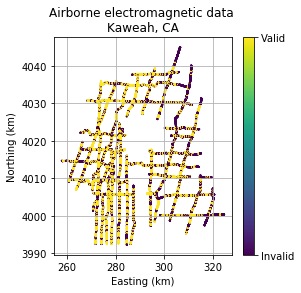

In [140]:
import matplotlib.pyplot as plt 
f,ax = plt.subplots(1,figsize=(4,4))
plt.scatter(df_raw.UTMX/1000,df_raw.UTMY/1000,c=df_raw.VALID,s=1)
cb = plt.colorbar()
cb.set_ticks([0,1])
cb.set_ticklabels(['Invalid','Valid'])
plt.xlabel("Easting (km)")
plt.ylabel("Northing (km)")
plt.title("Airborne electromagnetic data \nKaweah, CA")
# cb.set_labels
ax.grid(True)
plt.savefig(repo.joinpath('Kaweah_lines.png'),dpi=300,bbox_inches='tight')

In [61]:
#Checkpoint
df_raw.to_pickle(datadir.joinpath('raw_processed.pkl'))

In [121]:
df = pd.read_pickle(datadir.joinpath('raw_processed.pkl'))

#### Drop any soundings where HM or LM is repeated

In [123]:
flag=0

#Do this line-by-line
ind_counter=0
df = df.set_index('TIMESTAMP').sort_index().reset_index()

# df.reset_index(drop=True,inplace=True)

for line_tmp in df.LINE_NO.unique():
    print(ind_counter,line_tmp)
#     if ind_counter!= 0:
#         break
    #Extract data from each line
    df_tmp = df.loc[df.LINE_NO==line_tmp,:]

    #Drop entries where the line starts w/ LM  or ends w/ HM
    last_ind = df_tmp.index.max()
    first_ind = df_tmp.index.min()
    if df.loc[last_ind].CHANNEL_NO==2:
        print('dropping last ind...')
        df.drop(index=last_ind,inplace=True)
    if df.loc[first_ind].CHANNEL_NO==1:
        df.drop(index=first_ind,inplace=True)
        print('dropping first ind...')

    #Drop entries where LM or HM is repeated
    repeat_inds = df_tmp.index[df_tmp.CHANNEL_NO.diff()==0]
    df.drop(index=repeat_inds,inplace=True)
    ind_counter+=1

df.sort_index(inplace=True)


0 101901
1 200901
2 200601
3 200401
4 100901
5 101001
6 201401
7 101101
8 201601
9 100801
10 100701
11 100601
12 201101
13 200301
14 200201
15 200101
16 100501
17 100301
18 100201
19 101601
20 101202
21 200203
22 200303
23 100203
24 100102
25 200802
26 201103
27 101702
28 101802
29 100602
30 101501
31 200501
32 2001001
33 101401
34 101301
35 100302
36 100401
37 201501
38 201701
39 201301
40 201201
41 200701
42 201202


### Verify that partnered LM and HM data have the same label (valid=true/false) 
This happens where the HM happens within 30m but the LM happens just over 30m from inverted location
<br>
Or where the LM happens outside 30m but the HM happens just within 30m of inverted location
<br><br>
##### Rule:
 - if HM is valid but LM not valid, accept LM
 - if HM is not valid but LM valid, reject HM
<br>



In [125]:
flag=0
for line_tmp in df.LINE_NO.unique():
    print('Line no: {}'.format(line_tmp))
    df_tmp = df.loc[df.LINE_NO==line_tmp]
    HMind = df_tmp.index[df_tmp.CHANNEL_NO==2]
    LMind = HMind+1
    hmValid_lmInvalid = np.logical_and(df_tmp.loc[HMind,'VALID'].values==True,
                                       df_tmp.loc[LMind,'VALID'].values==False)
        
    #Update rows and re-insert
    rows = df_tmp.loc[LMind[hmValid_lmInvalid]].copy()
    rows.VALID=True
    df_tmp.loc[rows.index] = rows
    print(rows.index)
    
    
    
    lmValid_hmInvalid = np.logical_and(df_tmp.loc[HMind,'VALID'].values==False,
                                       df_tmp.loc[LMind,'VALID'].values==True)

    rows = df_tmp.loc[LMind[lmValid_hmInvalid]].copy()
#     print(rows.VALID)
    print(rows.index)

    rows.VALID=False
    df_tmp.loc[rows.index] = rows

    #Stack df_tmp to create df_new
    if flag==0:
        df_new = df_tmp.copy()
        flag=1
    else:
        df_new = df_new.append(df_tmp)

df = df_new.copy()


Line no: 101901


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Line no: 200901
Line no: 200601
Line no: 200401
Line no: 100901
Line no: 101001
Line no: 201401
Line no: 101101
Line no: 201601
Line no: 100801
Line no: 100701
Line no: 100601
Line no: 201101
Line no: 200301
Line no: 200201
Line no: 200101
Line no: 100501
Line no: 100301
Line no: 100201
Line no: 101601
Line no: 101202
Line no: 200203
Line no: 200303
Line no: 100203
Line no: 100102
Line no: 200802
Line no: 201103
Line no: 101702
Line no: 101802
Line no: 100602
Line no: 101501
Line no: 200501
Line no: 2001001
Line no: 101401
Line no: 101301
Line no: 100302
Line no: 100401
Line no: 201501
Line no: 201701
Line no: 201301
Line no: 201201
Line no: 200701
Line no: 201202


### Check that there are no more hmValid_lmInvalid or lmValid_hmInvalid

In [126]:
for line_tmp in df.LINE_NO.unique():
    df_tmp = df.loc[df.LINE_NO==line_tmp]
    HMind = df_tmp.index[df_tmp.CHANNEL_NO==2]
    LMind = HMind+1

    hmValid_lmInvalid = np.logical_and(df_tmp.loc[HMind,'VALID'].values==True,
                                       df_tmp.loc[LMind,'VALID'].values==False)
    lmValid_hmInvalid = np.logical_and(df_tmp.loc[LMind,'VALID'].values==True,
                                   df_tmp.loc[HMind,'VALID'].values==False)

    print(line_tmp,np.any(hmValid_lmInvalid),np.any(lmValid_hmInvalid))

101901 False False
200901 False False
200601 False False
200401 False False
100901 False False
101001 False False
201401 False False
101101 False False
201601 False False
100801 False False
100701 False False
100601 False False
201101 False False
200301 False False
200201 False False
200101 False False
100501 False False
100301 False False
100201 False False
101601 False False
101202 False False
200203 False False
200303 False False
100203 False False
100102 False False
200802 False False
201103 False False
101702 False False
101802 False False
100602 False False
101501 False False
200501 False False
2001001 False False
101401 False False
101301 False False
100302 False False
100401 False False
201501 False False
201701 False False
201301 False False
201201 False False
200701 False False
201202 False False


### Check that always alternating between LM/HM

In [127]:
for line_tmp in df.LINE_NO.unique():
    df_tmp = df.loc[df.LINE_NO==line_tmp]
    print(line_tmp,df_tmp.CHANNEL_NO.diff().unique())
#     print(line_tmp,np.any(hmValid_lmInvalid),np.any(lmValid_hmInvalid))

101901 [nan -1.  1.]
200901 [nan -1.  1.]
200601 [nan -1.  1.]
200401 [nan -1.  1.]
100901 [nan -1.  1.]
101001 [nan -1.  1.]
201401 [nan -1.  1.]
101101 [nan -1.  1.]
201601 [nan -1.  1.]
100801 [nan -1.  1.]
100701 [nan -1.  1.]
100601 [nan -1.  1.]
201101 [nan -1.  1.]
200301 [nan -1.  1.]
200201 [nan -1.  1.]
200101 [nan -1.  1.]
100501 [nan -1.  1.]
100301 [nan -1.  1.]
100201 [nan -1.  1.]
101601 [nan -1.  1.]
101202 [nan -1.  1.]
200203 [nan -1.  1.]
200303 [nan -1.  1.]
100203 [nan -1.  1.]
100102 [nan -1.  1.]
200802 [nan -1.  1.]
201103 [nan -1.  1.]
101702 [nan -1.  1.]
101802 [nan -1.  1.]
100602 [nan -1.  1.]
101501 [nan -1.  1.]
200501 [nan -1.  1.]
2001001 [nan -1.  1.]
101401 [nan -1.  1.]
101301 [nan -1.  1.]
100302 [nan -1.  1.]
100401 [nan -1.  1.]
201501 [nan -1.  1.]
201701 [nan -1.  1.]
201301 [nan -1.  1.]
201201 [nan -1.  1.]
200701 [nan -1.  1.]
201202 [nan -1.  1.]


In [129]:
df.to_pickle(datadir.joinpath('raw_processed_validated.pkl'))